# CHAPTER 3 word2vec

'추론 기반 기법'을 이용한 단어의 분산 표현  
추론 과정에 신경망을 이용하는데, 여기서 word2vec을 이용함

## 3.1 추론 기반 기법과 신경망

### 3.1.1 통계 기반 기법의 문제점

통계 기반 기법은 주변 단어의 빈도를 기초로 단어를 표현함
현업에서 다루는 말뭉치의 어휘 수는 양이 방대하여 이 방식은 대규모 말뭉치를 다룰 때 문제가 발생  
    
<img src='./img/3/word2vec_1.png' width=500>  
  
통계 기반 기법은 말뭉치 전체의 통계(동시발생 행렬과 PPMI 등)을 이용해 단 1회의 처리(SVD 등)만에 단어의 분산 표현을 얻는 반면,  
추론 기반 기법에서는, 미니배치 학습에서 신경망이 한 번에 소량(미니배치)의 학습 샘플씩 반복해서 학습하며 가중치를 갱신함  
따라서, 말뭉치의 어휘 수가 많아 SVD 등 계산량이 큰 작업을 처리하기 어려운 경우에도 신경망을 학습시킬 수 있음

### 3.1.2 추론 기반 기법 개요

추론 기반 기법에서는 추론이 주된 작업  
  
<img src='./img/3/word2vec_2.png' width=300>  
  
여기서, 추론이란 위 그림과 같이 주변 단어(맥락)가 주어졌을 때 "?"에 무슨 단어가 들어가는지를 추측하는 작업을 의미  
추론 문제를 반복해서 풀면서 단어의 출현 패턴을 학습함  
  
<img src='./img/3/word2vec_3.png' width=500>  
  
추론 기반 기법에서는 신경망 모델을 사용  
모델은 맥락 정보를 입력받아 (출현할 수 있는) 각 단어의 출현 확률을 출력함  
말뭉치를 사용해 모델이 올바른 추측올 내놓도록 학습을 하고,  
단어의 분산 표현을 얻는 것이 추론 기반 기법의 큰 틀  
  
추론 기반 기법도 통계 기반 기법처럼 분포 가설('단어의 의미는 주변에 의해 형성된다')에 기초함  
두 기법 모두 분포 가설에 근거하는 '단어의 동시발생 가능성'을 얼마나 잘 모델링하는가가 중요한 연구 주제임

### 3.1.3 신경망에서의 단어  처리

신경망에서 단어를 처리하기 위해 먼저 '고정 길이의 벡터'로 변환해야 함  
  
ex)
<img src='./img/3/word2vec_4.png' width=300>  

벡터의 원소 중 하나만 1이고 나머지는 모두 0인 원핫 표현(원핫 벡터)로 변환  
단어를 고정 길이 벡터로 변환함으로써 신경망의 입력층 뉴런의 수를 고정할 수 있음  
  
<img src='./img/3/word2vec_5.png' width=500>  
  
위 예시의 경우, 입력층의 뉴런은 총 7개  
이 7개의 뉴런은 차례로 7개의 단어들에 대응됨  
이로써 단어를 벡터로 나타내어 신경망으로 단어를 처리할 수 있음  
  
<img src='./img/3/word2vec_6.png' width=500>  
<img src='./img/3/word2vec_7.png' width=500>  
  
가중치(매개변수)와 입력층 뉴런과의 가중합이 은닉층의 뉴런이 됨  
    
< 참고 >  
이번 장의 예시에서는 편향을 생략함  
편향을 이용하지 않는 완전연결계층은 '행렬 곱' 계산에 해당함  
딥러닝 프레임워크들은 일반적으로 완전연결계층을 생성할 때 편향을 이용할지 선택할 수 있도록 함  
  


In [1]:
import numpy as np

c = np.array([[1,0,0,0,0,0,0]]) # 입력(원핫 벡터)
W = np.random.randn(7,3) # 가중치
h = np.matmul(c,W) # 중간 노드(은닉층)
print(h)

[[ 0.88858884 -1.31849453  0.57897869]]


c는 원핫 표현이므로 c와 W의 행렬 곱 결과는 결국 가중치의 행벡터 하나를 뽑아낸 것과 같음  
(행렬 곱으로 계산하는 다소 비효율적인 부분에 대해서 4장에서 개선할 예정)

__MatMul 계층__으로 구현

In [2]:
import numpy as np
from common.layers import MatMul

c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7,3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-1.58524376  0.45803117  0.58089526]]


## 3.2 단순한 word2vec

### 3.2.1 CBOW 모델의 추론 처리

word2vec에서 사용되는 신경망은 CBOW(continuous bag-of-words)모델과 skip-gram 모델이 있음  
CBOW 모델은 맥락으로부터 타깃(target)을 추측하는 용도의 신경망  
여기서, '타깃'은 중앙 단어이고 그 주변 단어들이 '맥락'을 의미  
  
CBOW 모델의 입력은 맥락이며, 맥락은 단어들의 목록임  
맥락은 원핫 표현으로 변환하여 사용  
  
<img src='./img/3/cbow_1.png' width=400>  
  
CBOW 모델은 위 그림과 같음  
입력층이 2개, 은닉층을 거쳐 출력층에 도달함  
두 입력층에서 은닉층으로의 변환은 <u>똑같은 완전연결계층(가중치는 $W_{in}$)이 처리함</u>  
은닉층에서 출력층 뉴런으로의 변환은 다른 완전연결계층(가중치는 $W_{out}$)이 처리함  
  
여기서, 입력층이 2개인 이유는 맥락으로 고려할 단어를 2개로 정했기 때문\!  
만약 맥락에 포함시킬 단어가 N개라면 입력층도 N개가 됨  
입력층이 여러개인 경우 은닉층 뉴런은 평균하여 계산함  
  
출력층의 뉴런은 하나하나가 가가각의 단어에 대응하며 각 단어의 '점수'를 뜻함  
점수가 높을수록 대응 단어의 출현 확률도 높아짐  
점수에 소프트맥스 함수를 적용하면 확률을 얻을 수 있음  
  
입력층에서 은닉층으로의 변환은 완전연결계층(가중치 $W_{in}$)에 의해 이뤄지며,  
이 가중치의 각 행이 해당 단어의 분산표현  
학습을 진행할수록 맥락에서 출현하는 단어를 잘 추측하는 방향으로 분산표현이 갱신됨  
  
은닉층의 뉴런 수를 입력층의 뉴런 수보다 적게 해야 함  
이렇게 해야 은닉층에는 단어 예측에 필요한 정보를 '간결하게' 담게 되며, 결과적으로 밀집벡터 표현을 얻을 수 있음  
  
이것이 word2vec의 전체 그림😃  

<img src='./img/3/cbow_2.png' width=500>  
  
계층 관점에서 CBOW 모델의 신경망을 보면,  
가장 앞 단에는 2개의 MatMul 계층이 있고, 이 두 계층의 출력을 더한 후 0.5를 곱하여 '평균'을 계산함  
이 평균값이 은닉층 뉴런이 됨  
마지막으로 뉴런에 또 다른 MatMul 계층을 적용하여 '점수'를 출력  
  
CBOW 모델은 활성화 함수를 사용하지 않음

__CBOW 모델의 추론 처리 구현__

In [3]:
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,1,0,0,0,0,0]])

# 가중치 초기화
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

# 계층 생성
# 입력층 측의 MatMul 계층은 맥락 수만큼 생성
# 입력층 측의 MatMul 계층은 가중치 W_in을 공유함
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer0.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[-0.69968619 -0.7433146  -1.98250714 -4.67367092 -0.78297611  2.33807495
   2.18039249]]


### 3.2.2 CBOW 모델의 학습

<img src='./img/3/cbow_3.png' width=500>  
  
출력층에서 나온 점수를 소프트맥스 함수에 적용하면 '확률'을 얻을 수 있음  
이 확률은 맥락(전후 단어)이 주어졌을 때 그 중앙에 어떤 단어가 출현하는지를 나타냄  
  
CBOW 모델의 학습에서는 올바른 예측을 할 수 있도록 가중치($W_{in}, W_{out}$)를 조정함  
단어 출현 패턴을 학습 시 어떤 말뭉치를 사용하느냐에 따라 단어의 분산 표현이 달라질 수 있음  
<img src='./img/3/cbow_4.png' width=500>  
  
이 신경망은 다중 클래스 분류를 수행하는 신경망이므로  
소프트맥스 함수를 이용해 점수를 확률로 변환하고, 그 확률과 정답 레이블로부터 교차 엔트로피 오차를 구한 후, 그 값을 손실로 사용해 학습을 진행함

### 3.2.3 word2vec의 가중치와 분산 표현

<img src='./img/3/cbow_5.png' width=500>  
  
word2vec에서 사용되는 신경망에는 두 가지 가중치가 있음
- 입력 측 완전연결계층의 가중치($W_{in}$)  
    각 행이 각 단어의 분산 표현
- 출력 측 완전연결계층의 가중치($W_{out}$)  
    단어의 의미가 인코딩된 벡터  
    출력 측 가중치는 각 단어의 분산 표현이 열 방향(수직 방향)으로 저장됨  
  
이 중 최종적으로 이용하는 단어의 분산 표현은  
일반적으로 word2vec(특히 skip-gram 모델)에서는 '입력 측의 가중치'만 최종 단어의 분산 표현으로 이용함  
  
< 참고 >  
word2vec과 비슷한 기법인 GloVe에서는 입력 측 가중치와 출력 측 가중치를 더했을 때 좋은 결과를 얻었음

## 3.3 학습 데이터 준비

### 3.3.1 맥락과 타깃

<img src='./img/3/cbow_6.png' width=500>  
  
CBOW의 경우
- 신경망의 입력 : 맥락  
- 정답 레이블 : 맥락에 둘러싸인 중앙의 단어, 타깃  
  
말뭉치에서 '맥락'과 '타깃'을 만드는 작업
1. 말뭉치 텍스트를 단어 ID로 변환

In [4]:
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


2. 단어 ID의 배열인 corpus로부터 맥락과 타깃을 만들어냄
  
<img src='./img/3/cbow_7.png' width=500>

In [5]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t==0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [6]:
contexts, target = create_contexts_target(corpus, window_size=1)

print('맥락:')
print(contexts)
print('타깃:')
print(target)

맥락:
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
타깃:
[1 2 3 4 1 5]


### 3.3.2 원핫 표현으로 변환

<img src='./img/3/cbow_8.png' width=700>  
  
이어서, 맥락과 타깃을 단어 ID에서 원핫 표현으로 변환

In [7]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

__데이터 준비 과정 정리__

In [8]:
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [9]:
print('맥락:')
print(contexts)
print('타깃:')
print(target)

맥락:
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]
타깃:
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


## 3.4 CBOW 모델 구현

- SimpleCBOW  
    입력 측의 맥락을 처리하는 MatMul 계층은 맥락에서 사용하는 단어의 수(윈도우 크기)만큼 만들어야 함  
    입력 측 MatMul 계층들은 모두 같은 가중치를 이용함 
  
- backward
    <img src='./img/3/cbow_10.png' width=500>

__CBOW 모델 구현__

In [10]:
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer0.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 3.4.1 학습 코드 구현

- Trainer  
    학습데이터로부터 미니배치를 선택한 다음  
    신경망에 입력해 기울기를 구하고  
    기울기를 Optimizer에 넘겨 매개변수를 갱신

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 693 |  반복 1 / 2 | 시간 0[s] | 손실 0.37
| 에폭 694 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 695 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 696 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 697 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 698 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 699 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 700 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 701 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 702 |  반복 1 / 2 | 시간 0[s] | 손실 0.40
| 에폭 703 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 704 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 705 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 706 |  반복 1 / 2 | 시간 0[s] | 손실 0.50
| 에폭 707 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 708 |  반복 1 / 2 | 시간 0[s] | 손실 0.30
| 에폭 709 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 710 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 711 |  반복 1 / 2 | 시간 0[s] | 손실 0.49
| 에폭 712 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 713 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 714 |  반복 1 / 2 | 시간 0[s] | 손실 0.49
| 에폭 715 |  반복 1 / 2 | 시간 0[s] | 손실 0.36
| 에폭 716 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 717 |  반복 1

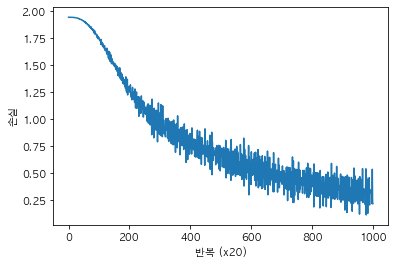

you [ 1.6988004  -1.1111257  -0.92101324 -0.96030444 -0.46292794]
say [1.272676   1.150973   1.1206589  1.0915618  0.47507647]
goodbye [-0.47584322 -0.8252023  -1.066985   -1.0764306  -1.2632858 ]
and [1.1194355 0.8509474 0.5668175 0.669281  1.7638085]
i [-0.46622515 -0.8064402  -1.0453433  -1.0594838  -1.2672657 ]
hello [ 1.6805035  -1.1124326  -0.94366574 -0.9750653  -0.45594916]
. [ 1.03731    1.1508136  1.2566137  1.1773102 -1.7481419]


In [17]:
import warnings
warnings.filterwarnings('ignore')
from common.trainer import Trainer
from common.optimizer import Adam
from ch03.simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

학습을 거듭할수록 손실이 줄어드는 것을 확인할 수 있음

## 3.5 word2vec 보충

### 3.5.1 CBOW 모델과 확률

CBOW 모델은 맥락을 주면 타깃 단어가 출현할 확률을 출력  
여기서, 말뭉치를 $w_1, w_2, \cdots, w_T$처럼 단어 시퀀스로 표기하고, t번째 단어에 대해 윈도우 크기가 1이라면  
맥락으로 $w_{t-1}$과 $w_{t+1}$이 주어졌을 때 타깃이 $w_{t}$가 될 확률은 다음과 같음  
$P(w_t|w_{t-1},w_{t+1})$  
  
이를 이용하면 CBOW 모델의 손실 함수도 간결하게 표현할 수 있음  
  
교차 엔트로피 오차 $L=-\sum_kt_klogy_k$  
  
- $y_k$ : k번째에 해당하는 사건이 일어날 확률
- $t_k$ : 정답 레이블(원핫 벡터)

여기서, $t_k$는 $w_t$에 해당하는 원소는 1, 나머지는 0이므로 다음 식을 유도할 수 있음  
  
$L=-logP(w_t|w_{t-1},w_{t+1})$  
  
위 식과 같이, CBOW 모델의 손실 함수는 단순히 확률에 log를 취한 다음 마이너스를 붙이면 됨  
이를 음의 로그 가능도(negative log likelihood)라고 함  
말뭉치 전체로 확장하면 다음 식이 됨  
  
$L=-\frac{1}{T}\sum_{t=1}^TlogP(w_t|w_{t-1},w_{t+1})$  
  
CBOW 모델의 학습이 수행하는 일은 이 손실 함수의 값을 가능한 작게 만드는 것  
또한, 이때의 가중치 매개변수가 우리가 얻고자 하는 단어의 분산 표현임

### 3.5.2 skip-gram 모델

word2vec에서 사용되는 신경망은 CBOW(continuous bag-of-words)모델과 skip-gram 모델이 있음  
    
<img src='./img/3/skip-gram_1.png' width=500>  
  
skip-gram 모델은 CBOW에서 다루는 맥락과 타깃을 역전시킨 모델  
중앙의 단어(타깃)로부터 주변의 여러 단어(맥락)을 추측함  
  
<img src='./img/3/skip-gram_2.png' width=500>  
  
skip-gram 모델은 입력층은 하나, 출력층은 맥락의 수만큼 존재함  
각 출력층에서는 Softmax with Loss 계층 등을 이용해 개별적으로 손실을 구하고 모두 더하여 최종 손실값을 계산함  
  
확률로 표기를 하면,  
중앙 단어(타깃)인 $w_t$로부터 맥락인 $w_{t-1}$과 $w_{t+1}$을 추측  
  
$P(w_{t-1},w_{t+1}|w_t)$  
  
여기서, 맥락의 단어들 사이에는 관련성이 없다고 가정하고 다음과 같이 분해하면('조건부 독립'이라고 가정) 다음 식이 되고,  
  
$P(w_{t-1},w_{t+1}|w_t)=P(w_{t-1}|w_t)P(w_{t+1}|w_t)$  
  
이어서 이를 교차 엔트로피 오차에 적용하면 손실 함수를 유도할 수 있음  
  
$L=-logP(w_{t-1},w_{t+1}|w_t)\\
=-logP(w_{t-1}|w_t)P(w_{t+1}|w_t)\\
=-(logP(w_{t-1}|w_t)+P(w_{t+1}|w_t))$  
  
식에서 알 수 있듯, skip-gram 모델의 손실 함수는 맥락별 손실을 구한 다음 모두 더함  
말뭉치 전체로 확장하면 손실 함수는 다음과 같음  
  
$L=-\frac{1}{T}\sum_{t=1}^T(logP(w_{t-1}|w_t)+logP(w_{t+1}|w_t))$  
  


CBOW 모델과 skip-gram 모델의 비교
- 단어 분산 표현의 정밀도 면에서 skip-gram 모델의 결과가 더 좋은 경우가 많음
- 말뭉치가 커질수록 저빈도 단어나 유추 문제의 성능 면에서 skip-gram 모델이 더 뛰어난 경향이 있음  
- 학습 속도 면에서는 CBOW 모델이 더 빠름
    skip-gram 모델은 손실을 맥락의 수만큼 구해야 하므로 계산 비용이 큼

__skip-gram 구현__

In [18]:
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

### 3.5.3 통계 기반 vs. 추론 기반

단어의 분산 표현을 갱신해야 할 상황이 생긴다면,  
통계 기반 기법은 계산을 처음부터 다시 해야 하는 반면,
추론 기반 기법(word2vec)은 학습한 가중치를 초깃값으로 사용해 매개변수를 다시 학습할 수 있음  
  
두 기법으로 얻는 단어의 분산 표현의 성격은  
통계 기반 기법은 주로 단어의 유사성이 인코딩되고,  
추론 기반 기법(특히 skip-gram 모델)에서는 단어의 유사성은 물론, 한층 복잡한 단어 사이의 패턴까지 파악되어 인코딩 됨  
  
하지만, __추론 기반 기법과 통계 기반 기법은 우열을 가릴 수 없음__  
  
그리고 추론 기반 기법과 통계 기반 기법은 서로 관련이 되어 있음  
skip-gram과 (다음 장에서 다루는) 네거티브 샘플링을 이용한 모델은 모두 말뭉치 전체의 동시발생 행렬에 특수한 행렬 분해를 적용한 것과 같음  
  
word2vec 이후 추론 기반 기법과 통계 기반 기법을 융합한 GloVe 기법도 등장했음  
GloVe는 말뭉치 전체의 통계 정보를 손실 함수에 도입해 미니배치를 학습함